In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json

## Data

In [3]:
PATH = Path('data/carvana')
MASKS_FN = 'train_masks.csv'
META_FN = 'metadata.csv'
masks_csv = pd.read_csv(PATH/MASKS_FN)
meta_csv = pd.read_csv(PATH/META_FN)

In [4]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

In [5]:
TRAIN_DN = 'train-128'
MASKS_DN = 'train_masks-128'
sz = 128
bs = 64
nw = 16

In [6]:
class MatchedFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
    def get_y(self, i): return open_image(os.path.join(self.path, self.y[i]))
    def get_c(self): return 0

In [7]:
x_names = np.array([Path(TRAIN_DN)/o for o in masks_csv['img']])
y_names = np.array([Path(MASKS_DN)/f'{o[:-4]}_mask.png' for o in masks_csv['img']])

In [8]:
val_idxs = list(range(1008))
((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, x_names, y_names)

In [9]:
aug_tfms = [RandomRotate(4, tfm_y=TfmType.PIXEL),
            RandomFlip(tfm_y=TfmType.PIXEL),
            RandomLighting(0.05, 0.05)]

In [10]:
tfms = tfms_from_model(vgg16, sz, crop_type=CropType.NO, tfm_y=TfmType.NO, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=16, classes=None)
denorm = md.trn_ds.denorm

## Simple upsample

In [11]:
f = vgg16
cut,lr_cut = model_meta[f]

In [12]:
def get_base():
    layers = cut_model(f(True), cut)
    return nn.Sequential(*layers)

In [13]:
def mask_loss(pred,targ):
    return F.binary_cross_entropy_with_logits(pred[:,0],targ[:,0])

def mask_acc(pred,targ): return accuracy_multi(pred[:,0], targ[:,0], 0.5)

In [14]:
def dice(pred, targs):
    m1 = (pred[:,0]>0).float()
    m2 = targs[:,0]
    return 2. * (m1*m2).sum() / (m1+m2).sum()

In [15]:
class StdUpsample(nn.Module):
    def __init__(self, nin, nout):
        super().__init__()
        self.conv = nn.ConvTranspose2d(nin, nout, 2, stride=2)
        self.bn = nn.BatchNorm2d(nout)
        
    def forward(self, x): return self.bn(F.relu(self.conv(x)))

In [16]:
class Upsample16(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.up1 = StdUpsample(512,256)
        self.up2 = StdUpsample(256,256)
        self.up3 = StdUpsample(256,256)
        self.up4 = StdUpsample(256,256)
        self.up5 = nn.ConvTranspose2d(256, 1, 2, stride=2)
        
    def forward(self,x):
        x = F.relu(self.rn(x))
        print('VGG end:', x.shape)
        x = self.up1(x)
        print('Up1:', x.shape)
        x = self.up2(x)
        print('Up2:', x.shape)
        x = self.up3(x)
        print('Up3:', x.shape)
        x = self.up4(x)
        print('Up4:', x.shape)
        x = self.up5(x)
        print('Up5:', x.shape)
        return x

In [17]:
m_base = get_base()

In [17]:
class UpsampleModel():
    def __init__(self,model,name='upsample'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.rn), [lr_cut]))
        return lgs + [children(self.model)[1:]]

In [ ]:
m = to_gpu(Upsample16(m_base))
models = UpsampleModel(m)

In [ ]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=mask_loss
learn.metrics=[mask_acc,dice]

In [ ]:
learn.freeze_to(1)

In [ ]:
x,y = next(iter(md.trn_dl))

In [ ]:
y.shape

In [ ]:
learn.lr_find()
learn.sched.plot()

In [28]:
lr=4e-2

In [ ]:
learn.fit(lr,1,cycle_len=4,use_clr=(20,8))

In [ ]:
learn.save('tmp')

In [ ]:
learn.load('tmp')

In [ ]:
learn.unfreeze()
learn.bn_freeze(True)
lrs = np.array([lr/100,lr/10,lr])/2

In [ ]:
learn.fit(lrs,1,cycle_len=4,use_clr=(20,8))

In [ ]:
learn.save('128urn-vgg16')

## U-net (ish)

In [18]:
[o.features.size() for o in m.sfs]

NameError: name 'm' is not defined

In [18]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
#         pdb.set_trace()
        self.features = output
    def remove(self): self.hook.remove()

In [19]:
class UnetBlock(nn.Module):
    def __init__(self, up_in, x_in, n_out):
        super().__init__()
        up_out = x_out = n_out//2
        self.x_conv  = nn.Conv2d(x_in,  x_out,  1)
        self.tr_conv = nn.ConvTranspose2d(up_in, up_out, 2, stride=2)
        self.bn = nn.BatchNorm2d(n_out)
        
    def forward(self, up_p, x_p):
#         print('Up_p:', up_p.shape)
#         print('x_p:', x_p.shape)
        up_p = self.tr_conv(up_p)
        x_p = self.x_conv(x_p)
#         print('After conv Up_p:', up_p.shape)
#         print('After conv x_p:', x_p.shape)
        cat_p = torch.cat([up_p,x_p], dim=1)
        return self.bn(F.relu(cat_p))

In [20]:
m_base = get_base()

In [22]:
m_base

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True

In [23]:
x.shape

NameError: name 'x' is not defined

In [ ]:
m_base

In [147]:
class Unet16(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.sfs = [SaveFeatures(rn[0][i]) for i in [5,12,22,32,42]]
        self.up1 = UnetBlock(512,512,512)
        self.up2 = UnetBlock(512,512,512)
        self.up3 = UnetBlock(512,256,256)
        self.up4 = UnetBlock(256,128,128)
        self.up5 = UnetBlock(128,64,128)
        self.up6 = nn.ConvTranspose2d(128, 1, 2, stride=2)
        
        
    def forward(self,x):
        
        x = F.relu(self.rn(x))
#         pdb.set_trace()

        for i in self.sfs:
            print('f', i.features.shape)
        print('After vgg:', x.shape)
#         x = self.up0(x)
#         print('Up0:', x.shape)
        print('Sfs4:', self.sfs[4].features.shape)
        x = self.up1(x, self.sfs[4].features)
        print('Up1:', x.shape)
        print('Sfs3:', self.sfs[3].features.shape)
        x = self.up2(x, self.sfs[3].features)
        print('Up2:', x.shape)
        print('Sfs2:', self.sfs[2].features.shape)
        x = self.up3(x, self.sfs[2].features)
        print('Up3:', x.shape)
        print('Sfs1:', self.sfs[1].features.shape)
        x = self.up4(x, self.sfs[1].features)
        print('Up4:', x.shape)
        print('Sfs0:', self.sfs[0].features.shape)
        x = self.up5(x, self.sfs[0].features)
        print('Up5:', x.shape)
        x = self.up6(x)
        
        print('Up6:', x.shape)
        return x

In [116]:
# This works, but we don't have a skip block right before the first max pool. Seems like unet should do that
class Unet16(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.sfs = [SaveFeatures(rn[0][i]) for i in [5,12,22,32,42]]
        self.up1 = UnetBlock(512,512,512)
        self.up2 = UnetBlock(512,512,512)
        self.up3 = UnetBlock(512,256,256)
        self.up4 = UnetBlock(256,128,128)
        self.up5 = UnetBlock(128,64,128)
        self.up6 = nn.ConvTranspose2d(128, 1, 2, stride=2)
        
        
    def forward(self,x):
        
        x = F.relu(self.rn(x))
        x = self.up1(x, self.sfs[4].features)
        x = self.up2(x, self.sfs[3].features)
        x = self.up3(x, self.sfs[2].features)
        x = self.up4(x, self.sfs[1].features)
#         x = self.up5(x, self.sfs[0].features)
        x = self.up6(x)
        return x

In [21]:
class Unet16(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.sfs = [SaveFeatures(rn[0][i]) for i in [5,12,22,32]]
        self.up0 = StdUpsample(512,512)
        self.up1 = UnetBlock(512,512,256)
        self.up2 = UnetBlock(256,256,256)
        self.up3 = UnetBlock(256,128,256)
        self.up4 = UnetBlock(256,64,256)
#         self.up5 = nn.ConvTranspose2d(256, 1, 2, stride=2)
        self.up5  = nn.Conv2d(256,  1,  1)
        
        
    def forward(self,x):
        
        x = F.relu(self.rn(x))
#         pdb.set_trace()

#         for i in self.sfs:
#             print(i.features.shape)
#         print('After vgg:', x.shape)
        x = self.up0(x)
#         print('Up0:', x.shape)
#         print('Sfs3:', self.sfs[3].features.shape)
        x = self.up1(x, self.sfs[3].features)
#         print('Up1:', x.shape)
#         print('Sfs2:', self.sfs[2].features.shape)
        x = self.up2(x, self.sfs[2].features)
#         print('Up2:', x.shape)
#         print('Sfs1:', self.sfs[1].features.shape)
        x = self.up3(x, self.sfs[1].features)
#         print('Up3:', x.shape)
#         print('Sfs0:', self.sfs[0].features.shape)
        x = self.up4(x, self.sfs[0].features)
#         print('Up4:', x.shape)
#         x = self.up5(x, self.sfs[0].features)
#         print('Up5:', x.shape)
        x = self.up5(x)
        
#         print('Up6:', x.shape)
        return x

In [34]:
class Unet16(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.sfs = [SaveFeatures(rn[0][i]) for i in [5,12,22,32,42]]
        self.up0 = UnetBlock(512,512,512)
        self.up1 = UnetBlock(512,512,256)
        self.up2 = UnetBlock(256,256,256)
        self.up3 = UnetBlock(256,128,256)
        self.up4 = UnetBlock(256,64,256)
#         self.up5 = nn.ConvTranspose2d(256, 1, 2, stride=2)
        self.up5  = nn.Conv2d(256,  1,  1)
        
        
    def forward(self,x):
        
        x = F.relu(self.rn(x))
#         pdb.set_trace()

#         for i in self.sfs:
#             print(i.features.shape)
#         print('After vgg:', x.shape)
        x = self.up0(x, self.sfs[4].features)
#         print('Up0:', x.shape)
#         print('Sfs3:', self.sfs[3].features.shape)
        x = self.up1(x, self.sfs[3].features)
#         print('Up1:', x.shape)
#         print('Sfs2:', self.sfs[2].features.shape)
        x = self.up2(x, self.sfs[2].features)
#         print('Up2:', x.shape)
#         print('Sfs1:', self.sfs[1].features.shape)
        x = self.up3(x, self.sfs[1].features)
#         print('Up3:', x.shape)
#         print('Sfs0:', self.sfs[0].features.shape)
        x = self.up4(x, self.sfs[0].features)
#         print('Up4:', x.shape)
#         x = self.up5(x, self.sfs[0].features)
#         print('Up5:', x.shape)
        x = self.up5(x)
        
#         print('Up6:', x.shape)
        return x

In [35]:
m = to_gpu(Unet16(m_base))

In [36]:
models = UpsampleModel(m)

In [37]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=mask_loss
learn.metrics=[mask_acc,dice]

In [38]:
learn.freeze_to(1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 20%|██        | 13/64 [00:06<00:25,  1.96it/s, loss=0.664] 


Exception in thread Thread-13:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



 92%|█████████▏| 59/64 [00:25<00:02,  2.28it/s, loss=1.65] 


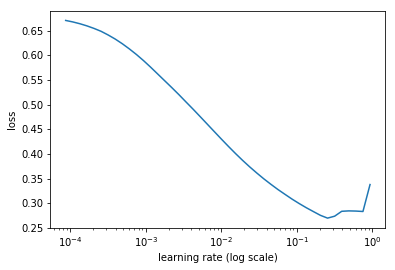

In [39]:
learn.lr_find()
learn.sched.plot()

In [30]:
learn.fit(lr,1,cycle_len=8,use_clr=(20,8))

HBox(children=(IntProgress(value=0, description='Epoch', max=8), HTML(value='')))

  8%|▊         | 5/64 [00:03<00:40,  1.46it/s, loss=0.48] 


Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   mask_acc   dice            
    0      0.056189   0.023357   0.991114   0.978327  
    1      0.029036   0.021422   0.990054   0.979519        
    2      0.021665   0.019618   0.991045   0.981298        
    3      0.018955   0.018098   0.99246    0.983159        
    4      0.017619   0.017517   0.993486   0.983923        
    5      0.016794   0.018719   0.991267   0.981906        
    6      0.016092   0.016324   0.993714   0.985131        
    7      0.015528   0.016103   0.993508   0.98526         



[0.01610265, 0.9935084395110607, 0.9852603533919028]

In [128]:
[o.features.size() for o in m.sfs]

[torch.Size([64, 64, 128, 128]),
 torch.Size([64, 128, 64, 64]),
 torch.Size([64, 256, 32, 32]),
 torch.Size([64, 512, 16, 16]),
 torch.Size([64, 512, 8, 8])]

In [31]:
learn.save('128urn-vgg16-tmp')

In [ ]:
learn.load('128urn-vgg16-tmp')

In [32]:
learn.unfreeze()
learn.bn_freeze(True)
lrs = np.array([lr/100,lr/10,lr])

In [33]:
learn.fit(lrs,1,cycle_len=40,use_clr=(20,10))

HBox(children=(IntProgress(value=0, description='Epoch', max=40), HTML(value='')))

epoch      trn_loss   val_loss   mask_acc   dice            
    0      0.015113   0.014647   0.994301   0.986513  
    1      0.014645   0.014557   0.993467   0.986174        
 52%|█████▏    | 33/64 [00:23<00:21,  1.42it/s, loss=0.0145]

KeyboardInterrupt: 

In [ ]:
learn.save('128urn-vgg16-0')

In [ ]:
learn.load('128urn-vgg16-0')

In [ ]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

In [ ]:
# ax = show_img(denorm(x)[0])
show_img(py[0][0]>0);

In [ ]:
# ax = show_img(denorm(x)[0])
show_img(y[0,...,-1]);

## 512x512

In [ ]:
sz=512
bs=16

In [ ]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.PIXEL, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=4, classes=None)
denorm = md.trn_ds.denorm

In [ ]:
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UpsampleModel(m)

In [ ]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=mask_loss
learn.metrics=[mask_acc,dice]

learn.freeze_to(1)

In [ ]:
learn.load('128urn-vgg16-0')

In [ ]:
learn.fit(lr,1,cycle_len=5,use_clr=(20,5))

In [ ]:
learn.save('512urn-vgg16-tmp')

In [ ]:
learn.unfreeze()
learn.bn_freeze(True)

In [ ]:
learn.fit(lrs,1,cycle_len=8,use_clr=(20,8))

In [ ]:
learn.save('512urn-vgg16')

In [ ]:
learn.load('512urn-vgg16')

In [ ]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

In [ ]:
show_img(py[0][0]>0);

In [ ]:
show_img(y[0,...,-1]);

## 1024x1024

In [ ]:
sz=1024
bs=4

In [ ]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.PIXEL, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=4, classes=None)
denorm = md.trn_ds.denorm

In [ ]:
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UpsampleModel(m)

In [ ]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=mask_loss
learn.metrics=[mask_acc,dice]

learn.freeze_to(1)

In [ ]:
learn.load('512urn-vgg16')

In [ ]:
learn.fit(lr,1,cycle_len=2,use_clr=(20,4))

In [ ]:
learn.save('1024urn-vgg16-tmp')

In [ ]:
learn.unfreeze()
learn.bn_freeze(True)

In [ ]:
learn.fit(lrs/2,1,cycle_len=4,use_clr=(20,8))

In [ ]:
learn.save('1024urn-vgg16')

In [ ]:
learn.load('1024urn-vgg16')

In [ ]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

In [ ]:
show_img(py[0][0]>0);

In [ ]:
show_img(y[0,...,-1]);